# Classificador de Laranjas -  Módulo de Aprendizado de Máquina

### 1. Importando as Dependências

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import pickle
import keras
from tqdm import tqdm
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils  import to_categorical
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D

### 2. Verificando Presença de uma GPU
O código abaixo realiza uma breve vericação no computador que está executando o código, vendo se este possui placa gráfica que esteja disponível para uso, caso haja, ele usará a mesma para o treinamento do modelo de dados, caso contrário, ele fará uso do processador da máquina para tal.

In [2]:
!pwd
tf
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices())
#???

/Users/guilherme/Desktop/UnB/DL/classificador-laranjas
Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]


### 3. Tratamento dos dados, utilizando visão computacional
Nesta função utlizamos o OpenCV, uma biblioteca de visão computacional, onde fazemos uso da função cvtColor(), função essa que converte uma imagem de um espaço de cores para outro. Também redimensionamos a imagem pra 100x100p, após fazer o carregamento desta. 

In [5]:
def load_rand():
    X=[]
    dir_path='./archive/dataset/train' #Diretorio dos dados de treinamento
    for sub_dir in tqdm(os.listdir(dir_path)):
        print(sub_dir)
        path_main=os.path.join(dir_path,sub_dir) #rottenoranges vs freshoranges
        print(path_main)
        i=0
        for img_name in os.listdir(path_main): #Loop in each directory ['fresh', 'rotten']
            print(img_name)
            if i>=12: #Read 18 images each directory (36 in total)
                break
            img=cv2.imread(os.path.join(path_main,img_name)) #read image
            img=cv2.resize(img,(100,100)) #resize image 100x100 pixels
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #convert image
            X.append(img)
            i+=1
    return X

X=load_rand()

  0%|          | 0/3 [00:00<?, ?it/s]

freshoranges
./archive/dataset/train/freshoranges
saltandpepper_Screen Shot 2018-06-12 at 11.55.42 PM.png
rotated_by_30_Screen Shot 2018-06-12 at 11.56.55 PM.png
saltandpepper_Screen Shot 2018-06-13 at 12.18.40 AM.png
rotated_by_30_Screen Shot 2018-06-13 at 12.08.41 AM.png
Screen Shot 2018-06-13 at 12.16.16 AM.png
rotated_by_60_Screen Shot 2018-06-13 at 12.04.01 AM.png
saltandpepper_Screen Shot 2018-06-13 at 12.10.45 AM.png
saltandpepper_Screen Shot 2018-06-13 at 12.04.34 AM.png
rotated_by_30_Screen Shot 2018-06-12 at 11.52.03 PM.png
saltandpepper_Screen Shot 2018-06-13 at 12.07.05 AM.png
Screen Shot 2018-06-13 at 12.15.27 AM.png
rotated_by_30_Screen Shot 2018-06-13 at 12.04.12 AM.png
rotated_by_45_Screen Shot 2018-06-12 at 11.59.54 PM.png
lessorange
./archive/dataset/train/lessorange
aug_3323.jpg
aug_1534.jpg
aug_1252.jpg
aug_2983.jpg
aug_2997.jpg
aug_1246.jpg
aug_1520.jpg
aug_2029.jpg
aug_3337.jpg
aug_1508.jpg
aug_2001.jpg


100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

aug_2767.jpg
aug_2773.jpg
rottenoranges
./archive/dataset/train/rottenoranges
rotated_by_30_Screen Shot 2018-06-12 at 11.37.58 PM.png
rotated_by_75_Screen Shot 2018-06-12 at 11.31.52 PM.png
rotated_by_30_Screen Shot 2018-06-12 at 11.23.29 PM.png
rotated_by_60_Screen Shot 2018-06-12 at 11.37.36 PM.png
rotated_by_75_Screen Shot 2018-06-12 at 11.43.49 PM.png
rotated_by_15_Screen Shot 2018-06-12 at 11.45.33 PM.png
Screen Shot 2018-06-12 at 11.43.36 PM.png
rotated_by_60_Screen Shot 2018-06-12 at 11.34.07 PM.png
rotated_by_30_Screen Shot 2018-06-12 at 11.37.25 PM.png
rotated_by_15_Screen Shot 2018-06-12 at 11.23.24 PM.png
rotated_by_30_Screen Shot 2018-06-12 at 11.23.54 PM.png
saltandpepper_Screen Shot 2018-06-12 at 11.33.55 PM.png
rotated_by_75_Screen Shot 2018-06-12 at 11.26.12 PM.png


In [6]:
X=np.array(X)
X.shape #36 linhas de imagens de 100x100 pixels com profundidade 3 (RGB)
#onde R é Vermelho, G é Verde e B é Azul

(36, 100, 100, 3)

Carrega as imagens e coloca labels para elas

## Laranja Boa

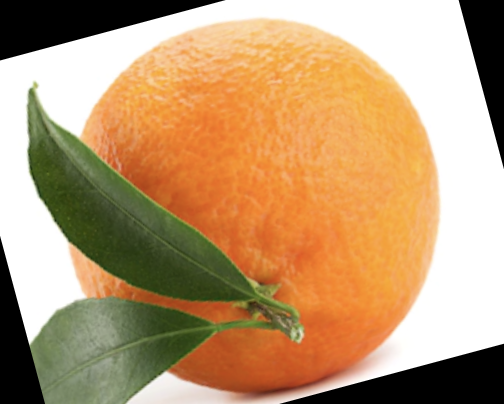

In [49]:
from IPython.display import Image
Image(filename='./archive/dataset/train/freshoranges/rotated_by_15_Screen Shot 2018-06-12 at 11.52.12 PM.png', width=255) 


## Laranja boa com manchas

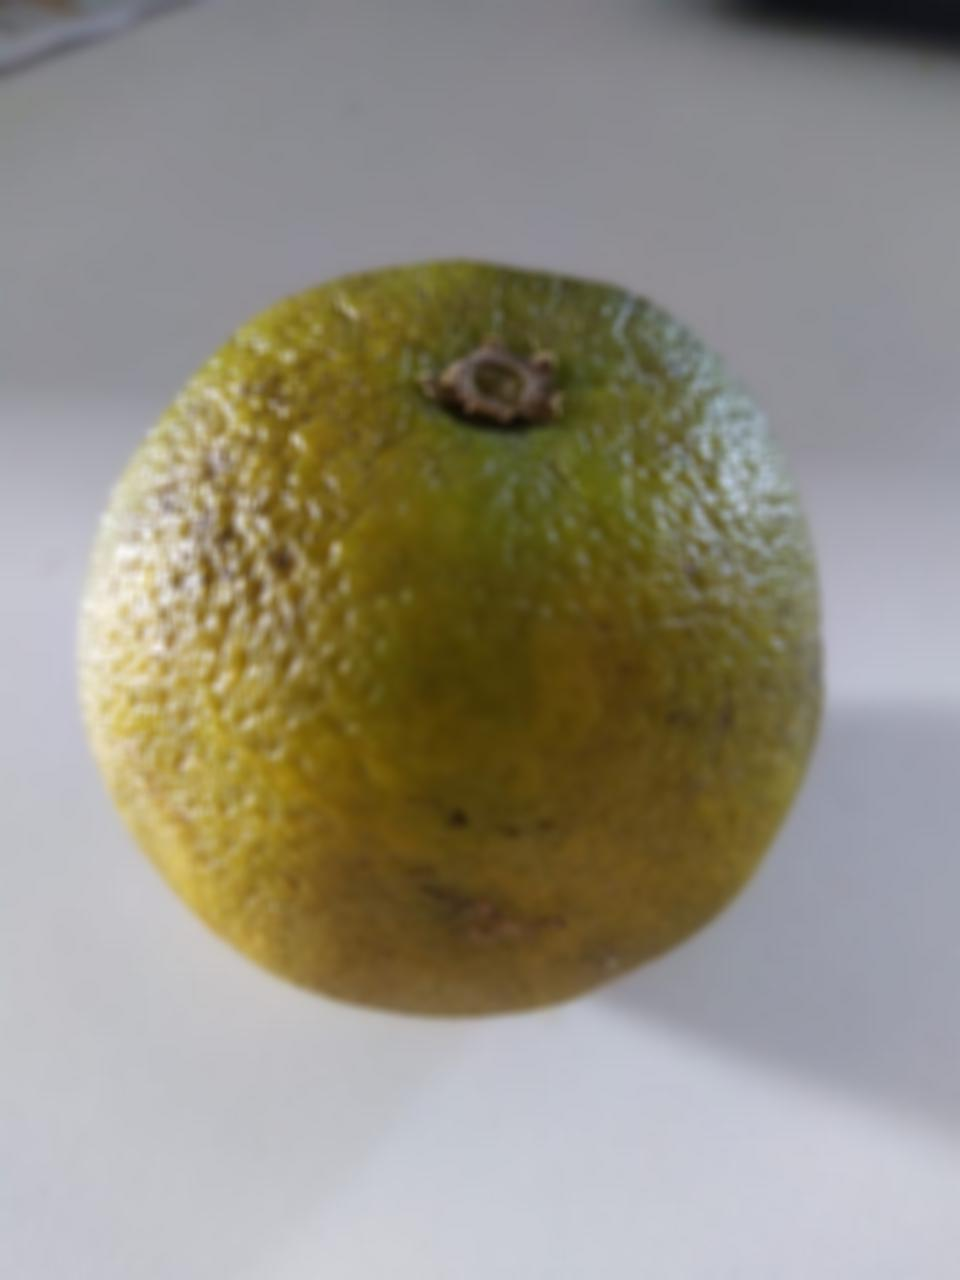

In [51]:
from IPython.display import Image
Image(filename='./archive/dataset/train/lessorange/aug_145.jpg', width=255) 

## Laranja ruim

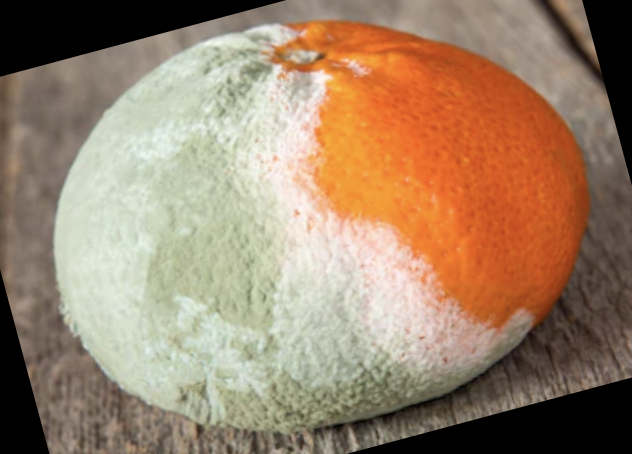

In [53]:
from IPython.display import Image
Image(filename='./archive/dataset/train/rottenoranges/rotated_by_15_Screen Shot 2018-06-12 at 11.21.17 PM.png', width=255) 

In [7]:
def load_rottenvsfresh():
    
    quality=['fresh', 'rotten', 'less']
    
    X,Y=[],[]
    z=[]
    #BOAS SEM MANCHAS -> LABEL 0
    #RUINS -> LABEL 1
    #BOA COM MANCHAS -> LABEL 2
    for cata in tqdm(os.listdir('./archive/dataset/train')):
        if quality[0] in cata:
            path_main=os.path.join('./archive/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0]) #fresh
        elif quality[1] in cata:
            path_main=os.path.join('./archive/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1]) #rotten
        else:
            path_main=os.path.join('./archive/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2]) #less
    
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y

In [8]:
X,Y=load_rottenvsfresh()

100%|██████████| 5344/5344 [00:00<00:00, 613755.77it/s]


In [7]:
Y=np.array(Y)
X=np.array(X)
y_ser=pd.Series(Y)
y_ser.value_counts()

2    2283
1    1595
0    1466
dtype: int64

In [24]:
def load_rottenvsfresh_valset():
    quality=['fresh', 'rotten', 'less']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('./archive/dataset/test')):
        if quality[0] in cata:
            path_main=os.path.join('./archive/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        elif quality[1] in cata:
            path_main=os.path.join('./archive/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1]) #rotten
        else:
            path_main=os.path.join('./archive/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2]) #less
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)        
    return X,Y      

In [26]:
X_val,Y_val=load_rottenvsfresh_valset()

100%|██████████| 1975/1975 [00:00<00:00, 551367.84it/s]


In [30]:
Y_val=np.array(Y_val)
X_val=np.array(X_val)
y_ser=pd.Series(Y_val)
y_ser.value_counts()

2    1180
1     406
0     389
dtype: int64

 ### 0. Criando e estruturando nossa Rede Neural
 Neste trecho do código, iniciamos com a definição do modelo como um modelo Sequencial. O modelo sequencial é um modelo que se sobresai quando se trata de uma pilha de camadas simples, tendo cada camada exatamento um tensor de entrada e outro de saída.
 


In [12]:
#Para construir o modelo, precisamos criar a arquitetura usando Sequential().
model = Sequential()

#Em seguida, adicionamos a primeira camada, uma camada de convolução para extrair 
#recursos da imagem de entrada e criamos 32 recursos convolutos 3 x 3 ReLu, 
#também conhecidos como mapas de recursos. Como esta é a primeira camada, devemos inserir a forma 
#da dimensão que é uma imagem de 100 x 100 pixels com profundidade = 3 (RGB).
model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', 
                 activation='relu', input_shape=(100,100,3)))

model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))

#A próxima camada será uma camada de pooling com um filtro de 2 x 2 pixels para obter o 
#elemento máximo dos mapas de feições. Isso reduz a dimensão dos mapas de recursos pela metade e 
#também é conhecido como subamostragem.
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

#Crie mais uma camada de convolução e camada de agrupamento como antes, mas sem o input_shape.
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
#Adicione uma camada de achatamento para reduzir a imagem a uma matriz linear, 
#também conhecida como um vetor de dimensão única, para alimentar e conectar-se à rede neural.
model.add(Flatten())
#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
#Agora crie uma rede neural onde a primeira camada tem 128 neurônios e a função de ativação ReLu .
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#Adicione uma camada de drop out com 30% de drop out.
model.add(Dropout(0.3))
#Crie a última camada desta rede neural usando a função softmax .
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
separable_conv2d (SeparableC (None, 100, 100, 32)      1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 50, 50, 64)        2

In [13]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=2, mode='max',
    min_lr=0.00002, cooldown=2)

check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='./rottenvs fresh.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

#compile o modelo, binary_crossentropy pois sao apenas 2 classes, otimizador adam e a precisao do modelo como metrica
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

Para agilização do processo de treinamento, diminuímos a dimensão da imagem, dividindo as matriz pela quantidade de colunas/linhas, visto que se trata de uma matriz quadrada.

Feito isso, partimos para a realização do fitting do dataset no modelo desenvolvido.

In [14]:
X=X/255.0
X_val=X_val/255.0

history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_val),epochs= 25,
                 callbacks=[check_point])

Epoch 1/25
268/268 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.8984
Epoch 00001: val_loss improved from inf to 28.41412, saving model to ./rottenvs fresh.h5
268/268 [==============================] - 171s 637ms/step - loss: 0.4586 - accuracy: 0.8984 - val_loss: 28.4141 - val_accuracy: 0.5975
Epoch 2/25
268/268 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9433
Epoch 00002: val_loss improved from 28.41412 to 1.11187, saving model to ./rottenvs fresh.h5
268/268 [==============================] - 139s 517ms/step - loss: 0.1634 - accuracy: 0.9433 - val_loss: 1.1119 - val_accuracy: 0.9195
Epoch 3/25
268/268 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9397
Epoch 00003: val_loss improved from 1.11187 to 0.19695, saving model to ./rottenvs fresh.h5
268/268 [==============================] - 141s 527ms/step - loss: 0.1757 - accuracy: 0.9397 - val_loss: 0.1970 - val_accuracy: 0.9727
Epoch 4/25
268/268 [============

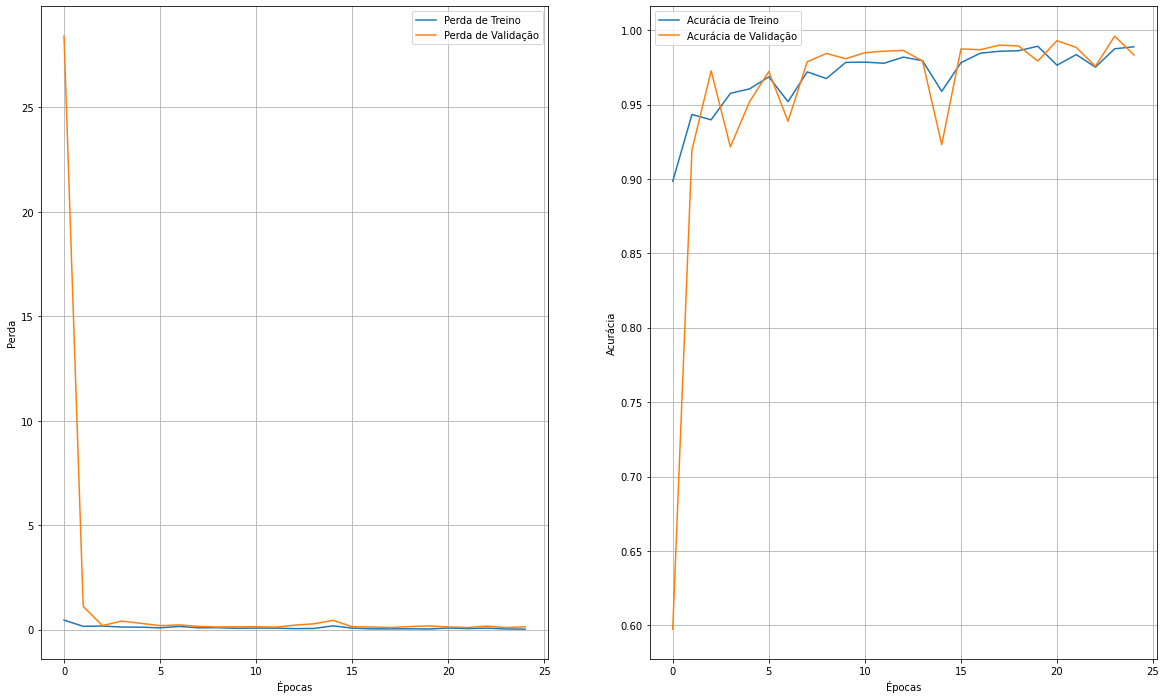

In [15]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.plot( history.history["loss"], label = "Perda de Treino")
plt.plot( history.history["val_loss"], label = "Perda de Validação")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.plot( history.history["accuracy"], label = "Acurácia de Treino")
plt.plot( history.history["val_accuracy"], label = "Acurácia de Validação")
plt.grid(True)
plt.legend()

Abaixo vemos uma avaliação do modelo e sua acurácia, esta resultando em 99.19% de precisão e perda de 0.0918

In [16]:
model.evaluate(X_val,Y_val)

62/62 [==============================] - 13s 206ms/step - loss: 0.1406 - accuracy: 0.9833


[0.14055030047893524, 0.9832911491394043]

Feito a avaliação do modelo, que resultou em margens aceitáveis, salvamos o modelo em formato *.h5 para uso na API que integrará a máquina.

In [17]:
model.save('./rottenvsfresh.h5')

Abaixo validamos a integridade do arquivo salvo

In [10]:
new_model=load_model('./rottenvsfresh.h5')

In [19]:
### Testando com imagem aleatória

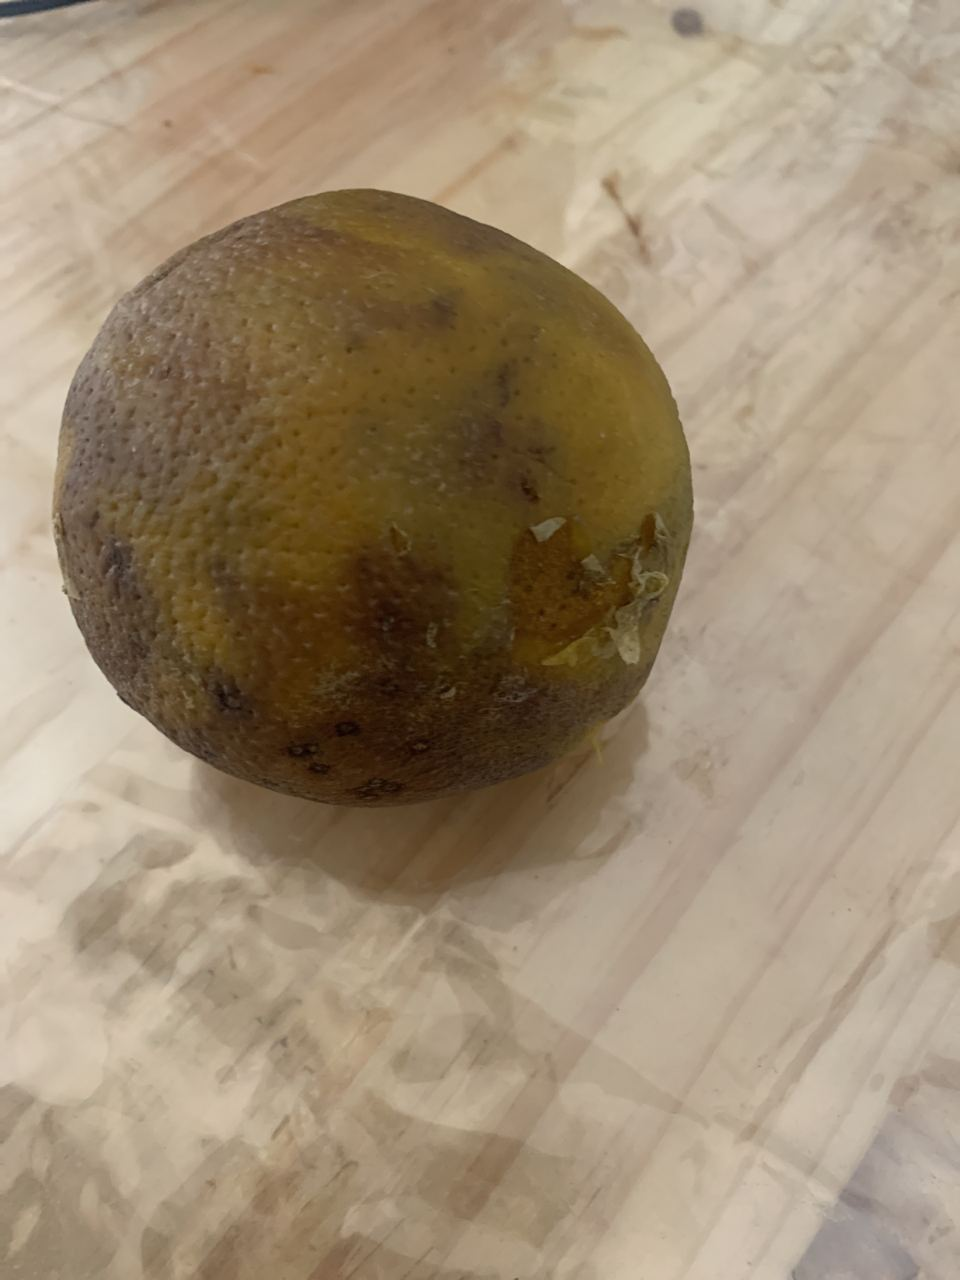

In [48]:
from IPython.display import Image
Image(filename='./archive/dataset/testejp.jpeg', width=255) 


In [47]:
I = []
img=cv2.imread('./archive/dataset/testejp.jpeg')
img=cv2.resize(img,(100,100))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
I.append(img)
NP_ARRAY = np.array(I)
X_VAL = NP_ARRAY/255.0
R = new_model.predict_classes(X_VAL)
if(R[0]==0):
    print('Laranja boa, sem manchas')
if(R[0]==1):
    print('Laranja ruim')
if(R[0]==2):
    print('Laranja boa, mas com manchas')
print(R[0])

Laranja ruim
1


In [32]:
res = new_model.evaluate(X_val,Y_val, return_dict = True)

62/62 [==============================] - 15s 244ms/step - loss: 842.1064 - accuracy: 0.6152
